## 1. Setup and Load Data

### 1.1 Install Dependencies and Setup

In [1622]:
#%pip install tensorflow opencv-python matplotlib #tensorflow - data planning pipeline, opencv - remove dodgy imgs, matplotlib -  visualize imgs

In [1623]:
#%pip list

In [1624]:
import tensorflow as tf
import os #navigate file structure
#os.path.join('data', 'happy') # -returns the folder structure
#os.listdir('data') #- list everythinng inside this folder

### 1.2 Remove dodgy images

In [1625]:
import cv2 
import imghdr #check file exts

In [1626]:
data_dir = 'data' #var to hold path to our data dir

In [1627]:
image_exts = ['jpg', 'jpeg', 'png', 'bmp'] 

In [1628]:
image_exts[2]
os.listdir(data_dir) # retyrns folders inside the data dir
#os.listdir(os.path.join(data_dir, 'happy')) # loop thru every single img

['happy', 'sad']

In [1629]:
for image_class in os.listdir(data_dir): #loop thru every folder in our data dir
    for image in os.listdir(os.path.join(data_dir, image_class)): #every single folder inside the data dir ie (data;happy) and (data;sad)
        image_path = os.path.join(data_dir, image_class, image) #every single img - data-happy-imgs/ data-sad-imgs
        try: 
            img = cv2.imread(image_path) #check we can load img into opencv
            tip = imghdr.what(image_path) #check it matches the exts
            if tip not in image_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path) #rempve if its weird 

        except Exception as e:
            print('issue with image {}'.format(image_path))
            #os.remove(image_path)

In [1630]:
# from matplotlib import pyplot as plt
# img = cv2.imread(os.path.join('data', 'happy', '0f2fc2d2e47c2e17fce6ad0849681825.jpg'))
# img
# img.shape
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #color conversion code
# plt.show()

### 1.3 Load Data

In [1631]:
#tensorflow has a dataset API - allows to build data piplelines rather than loading everything into memory, which gives you a repeatable set of steps to apply to our data 
#tf.data.Dataset?? #documentation

In [1632]:
import numpy as np
from matplotlib import pyplot as plt

In [1633]:
#tf.keras.utils.image_dataset_from_directory??

In [1634]:
data = tf.keras.utils.image_dataset_from_directory('data') #allows us to pull in our img data from our data folder - builds an img dataset for you
      #building our data pipeline

Found 379 files belonging to 2 classes.


In [1635]:
data_iterator = data.as_numpy_iterator() # allow us to access generator from our data pipeline...
     #allowing us to access our data pipeline ie loop thru the data pipleine

In [1636]:
#get another batch from the iterator

batch = data_iterator.next() #accessing the data pipeline itself ie grab one batch back

In [1637]:
len(batch)  #1.imgs (imgs from our dir loaded into memory as a set of numpy arrays) 2.labels

2

In [1638]:
#1. images represented as numpy arrays
batch[0].shape #automaticaly reshapes to ensure they're of the same size


#if you wanted a diff size img
#data = tf.keras.utils.image_dataset_from_directory('data', batch_size=8, image_size=(128,128)) #- however you sih your data set to look like

(32, 256, 256, 3)

In [1639]:
#2. label representation
batch[1] #labels: class 1 = sad ppl class 0 = happy ppl

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0], dtype=int32)

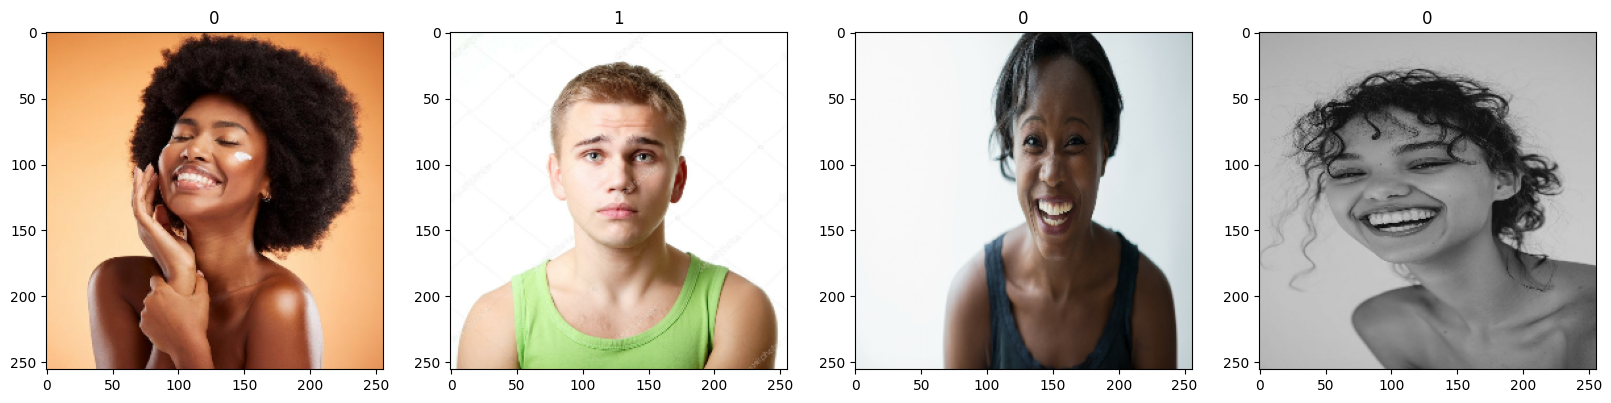

In [1640]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Preprocess data

### 2.1 Scale data

In [1641]:
#scaling imgs btwn 0 and 1 rather than 0 to 255 ; 
batch[0].shape
batch[0].max() #-initially gives 0
batch[0].max() #-initially gives 255

np.float32(255.0)

In [1642]:
data = data.map(lambda x,y: (x/255, y)) #divide by 255 to scale ... to scale one batch: batch[0] / 255
         #but because we are using a data pipeline, we dont want to scale every single time we load in new batch
         # we wanna do it as we load in the data in the pipeline using the data capabilities
         #data.map allows us to apply to perfomr this scaling transformation in the pipleine itself ie across the dataset
         # x - imgs/255, no transformation on y;labels

In [1643]:
data.as_numpy_iterator().next()[1].max()

np.int32(1)

In [1644]:
scaled_iterator = data.as_numpy_iterator() 

In [1645]:
batch = scaled_iterator.next()

In [1646]:
batch[0].max()

np.float32(1.0)

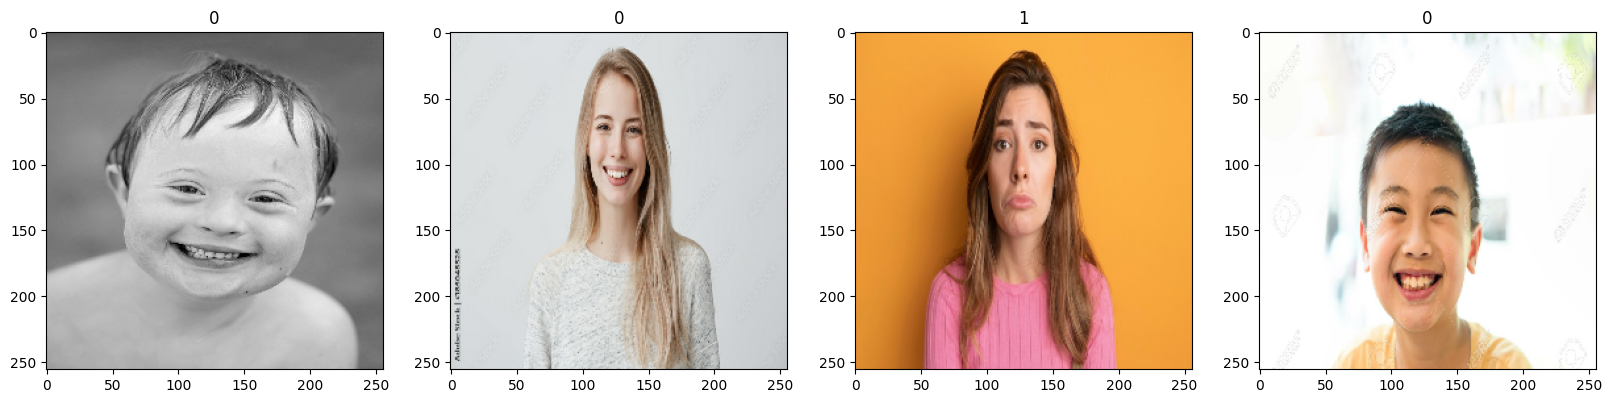

In [1647]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #we remove astype(int) because at this point we have scaled our data and it is betwen 0 and 1 not 0 and 255
    ax[idx].title.set_text(batch[1][idx])

### 2.2 Split data

In [1648]:
#now we split our data into a training and testing partition
len(data) #what is our training data size? - 5 batches, each has 32 imgs

12

In [1649]:
train_size = int(len(data)*.7) #70% of data
val_size = int(len(data)*.2) #20% of data
test_size = int(len(data)*.1)+1 #10% of data

In [1650]:
train_size #3 * 32 - what is actually used to train our deep leaarning model - pre
val_size #1 * 32 - what is actually used to evaluate our deep learning model while were training -pre
test_size #1 - hold this all the way this the end - post 
train_size + val_size + test_size

12

In [1651]:
#using the take and skip methods inside of tensorflow datapipleine
#take - how much data we will take in in that particular partition
#you need to shuffle your data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

In [1652]:
len(test)

2

## 3. Deep model

### 3.1 Build the Deep learning Model

In [1653]:
#build a deep learning model using the keras sequential API - the 'AI bit'

In [1654]:
from tensorflow.keras.models import Sequential #-model building API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #convolutional neural network layer...goes thru your imgs and condences them down... 

In [1655]:
model = Sequential() #create a model - establishing an instance of our sequential class

In [1656]:
#aadding in our layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #adding a convolutional and maxpooling layer, 16filters, 3px by3px in size, move 1px at a time,
                                 #activation - takes any output from the convolutional layer pass it thru a function; convert -ve vals to 0 and =ve remain - taking into acc non linear pattern
                                 #specify our output
model.add(MaxPooling2D()) #scan across the max val after relu activation and return it

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #condense the rows and width, num of filters will be the channel val...when passing to Dense, we dont want the channek val..rather condense it to a single val

model.add(Dense(256, activation='relu')) #256 neurons
model.add(Dense(1, activation='sigmoid')) #we get a single dense layer...sigmoid activation..output will effectively rep 0 and 1 mapping to our happy and sad...


In [1657]:
#now we compile the above
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # adam optimizer, specify what our loss is..track accuracy to show how well our model is classifying as either 0 or 1

In [1658]:
model.summary() #maxpooling kayer - 254/2 ->127; 30*30*16=14400(single dimension)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Train

In [1659]:
#first create a log directory
logdir = 'logs' #var that points to it

In [1660]:
#create a call back if you wanna save module as a particular checkpoint, do specific logging...
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log out your model training as its training...

In [ ]:
#fit our mode
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback]) #train data, how long we will train for; 1epoch=onr run over our entiretraining set of data
                       #run evaluation on data, if we wanted to log out all info from the model to tensorboard


#losses go down steadily, accuracy go up steadily...performing well by the end..100%

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6248 - loss: 0.8504 - val_accuracy: 0.6875 - val_loss: 0.5517
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step - accuracy: 0.6468 - loss: 0.6208 - val_accuracy: 0.5781 - val_loss: 0.7466
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.7528 - loss: 0.5434

### 3.3 Plot performance

In [ ]:
#because we saved our training history we can get a bunch of info
hist.history

In [ ]:
#visualize loss - steadily decreasing

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_oss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#if val_loss is going up steadily...model may be overfeeding..apply some "regulization"
#we can visualize more metrics

In [ ]:
#visualize accuracy - steadily increasing

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Evaluate performance

### 4.1 Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy #metrics used for classification

In [ ]:
#establish instances of the metrics and then update state as we make predictions
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
#in order to test them out:
for batch in test.as_numpy_iterator(): #loop thru each batch to bring it back
    X,y = batch #unpack it
    yhat = model.predict(X) #return set of vals between 0 and 1
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

#we can see how it actually performed on our test data

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}') #high val means youre performing better

### 4.2 Test

In [ ]:
#read in an img our model has not seen before
img = cv2.imread('sadtest3.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #opencv reads the img as bgr instead of rgb
plt.show()

In [ ]:
#img need s to be 256 256 3
#so resize before we run it to our neaural network
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = tf.image.resize(img_rgb, (256, 256))
plt.imshow(img_resized.numpy().astype(int))
plt.show()

In [ ]:
#test 
yhat = model.predict(np.expand_dims(resize/255, 0)) #pass it thru our neural network

#our neural network expects us to pass thru a batch of imgs not a single img - so encapsulate it inside another set of parens or put it inside a list or array


In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

## 5. Save model

### 5.1 Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#model.save(os.path.join('models', 'happy_sad_classifier_v1.keras'))

In [ ]:
#new_model = model.save(os.path.join('models', 'happy_sad_classifier_v1.keras'))

In [ ]:
#yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# Save the model
model.save(os.path.join('models', 'happy_sad_classifier_v1.keras'))

# Load the model
new_model = load_model(os.path.join('models', 'happy_sad_classifier_v1.keras'))

# Prepare the input
input_data = np.expand_dims(resize / 255.0, axis=0)

# Make predictions
yhat_new = new_model.predict(input_data)

# Interpret predictions
if yhat_new > 0.5:
    print(f"Predicted class is Sad")
else:
    print(f"Predicted class is Happy")


In [ ]:
##review the model testing